<a href="https://colab.research.google.com/github/IlyaOdnodvorets/nn2022/blob/main/Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Лабораторна робота №5**
##Виконав студент групи КН-31 Однодворець Ілля

---

##Завдання
1. На основі документу вирішити завдання класифікації зображень їжі для 3 класів з набору даних food101
2. Індекси класів визначити індивідуально за залежностями: i1=n-1,i2=n+29,i3=n+59 (де і1,і2,і3 - індекс класу (починаючи з 0) у відсортованому за алфавітом наборі даних, n - номер за списком групи.
3. Результати оформити у вигляді файлу з кодом для моделювання та візуалізації у форматі .ipynb
4. Результати викласти у репозиторії GitHub (папка Lab5).
5. Підготуватися до захисту лабораторної роботи (пояснення коду, відповіді на запитання за темою)
---

Завантажимо дані

In [ ]:
import zipfile
import os

# Download zip file of pizza_steak images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("101_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-06-04 10:24:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  67.2MB/s    in 24s     

2022-06-04 10:25:18 (65.7 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



Визначемо необхідні данні за варіантом (i1=15,i2=45,i3=75)

In [ ]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path("101_food_classes_10_percent/train/") # turn our training path into a Python path
all_class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories

my_class_names = [all_class_names[15],all_class_names[45] , all_class_names[75]]
print(my_class_names)

['ceviche', 'frozen_yogurt', 'pho']


Видалимо всі папки, крім класів за варіантом

In [ ]:
from pathlib import Path
import shutil

for path in all_class_names:
  if path != my_class_names[0] and path != my_class_names[1] and path != my_class_names[2]:
    dirpath = Path('101_food_classes_10_percent/train') / path
    if dirpath.exists() and dirpath.is_dir():
        shutil.rmtree(dirpath)
    dirpath = Path('101_food_classes_10_percent/test') / path
    if dirpath.exists() and dirpath.is_dir():
        shutil.rmtree(dirpath)

Виведемо випадкове зображення

In [ ]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (512, 512, 3)


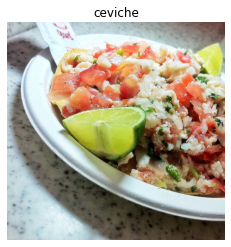

In [ ]:
# View a random image from the training dataset
img = view_random_image(target_dir="101_food_classes_10_percent/train/",
                        target_class="ceviche")

Перетворюємо зображення на данні (шляхи до навчальних та тестових даних змінені місцями через к-сть даних)

In [ ]:
# Define training and test directory paths
train_dir = "101_food_classes_10_percent/test/"
test_dir = "101_food_classes_10_percent/train/"

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical')

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')

Found 750 images belonging to 3 classes.
Found 225 images belonging to 3 classes.


Змінимо наші дані, щоб модель мала більш різноманітні зображення

In [ ]:
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                  target_size=(224, 224),
                                                                  batch_size=32,
                                                                  class_mode='categorical')

Found 750 images belonging to 3 classes.


Створемо та навчимо модель



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model_11 = Sequential([
  Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(32, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(3, activation='softmax')
])

model_11.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history_11 = model_11.fit(train_data_augmented,
                          epochs=20,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data))

Epoch 1/20
24/24 [==============================] - 23s 455ms/step - loss: 1.9847 - accuracy: 0.3867 - val_loss: 1.0862 - val_accuracy: 0.4444
Epoch 2/20
24/24 [==============================] - 11s 452ms/step - loss: 1.0807 - accuracy: 0.4280 - val_loss: 1.0738 - val_accuracy: 0.4311
Epoch 3/20
24/24 [==============================] - 12s 486ms/step - loss: 1.0614 - accuracy: 0.4560 - val_loss: 1.0263 - val_accuracy: 0.4622
Epoch 4/20
24/24 [==============================] - 11s 447ms/step - loss: 1.0391 - accuracy: 0.4853 - val_loss: 1.0365 - val_accuracy: 0.4711
Epoch 5/20
24/24 [==============================] - 11s 445ms/step - loss: 1.0324 - accuracy: 0.4667 - val_loss: 1.0543 - val_accuracy: 0.4578
Epoch 6/20
24/24 [==============================] - 11s 462ms/step - loss: 1.0026 - accuracy: 0.5267 - val_loss: 0.9561 - val_accuracy: 0.5511
Epoch 7/20
24/24 [==============================] - 11s 465ms/step - loss: 0.9804 - accuracy: 0.5507 - val_loss: 0.9979 - val_accuracy: 0.5200

In [ ]:
model_11.save('saved_model')

INFO:tensorflow:Assets written to: saved_model/assets


Графічно зобразимо значення при навчанні нашої моделі

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

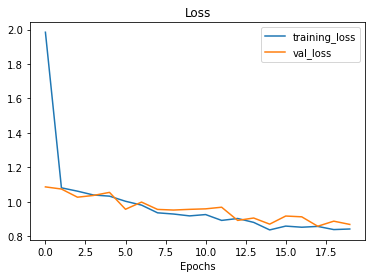

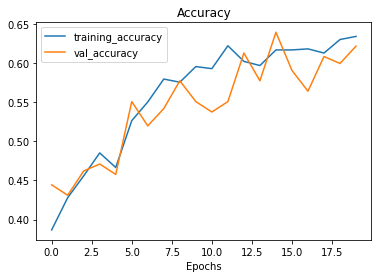

In [ ]:
plot_loss_curves(history_11)

Зробимо прогнозування за допомогою навченої моделі

In [ ]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [ ]:
# Adjust function to work with multi-class
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

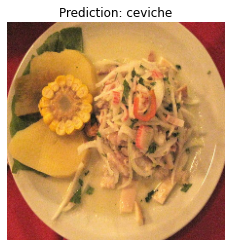

In [ ]:
pred_and_plot(model_11, "101_food_classes_10_percent/train/ceviche/322326.jpg", my_class_names)

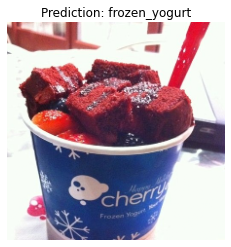

In [ ]:
pred_and_plot(model_11, "101_food_classes_10_percent/train/frozen_yogurt/252679.jpg", my_class_names)

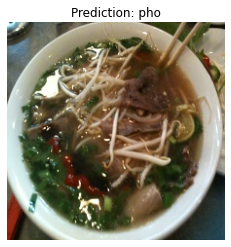

In [ ]:
pred_and_plot(model_11, "101_food_classes_10_percent/train/pho/120533.jpg", my_class_names)

## Висновок
У ході лабораторної роботи було набуто практичних навичок з вирішення задачі класифікації зображень за допомогою нейронної мережі.